In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
pd.set_option('display.max_rows', 40)

# from vivarium_research_prl.noise import corruption, fake_names, noisify
# from vivarium_research_prl.find_kids import datasets, noisify_data
# import vivarium_research_prl.find_kids as find_kids

from splink.duckdb.duckdb_linker import DuckDBLinker
import splink.duckdb.duckdb_comparison_library as cl

# For viewing waterfall charts and precision-recall curve
import altair as alt
alt.renderers.enable('mimetype')
alt.renderers.enable('html')

# For viewing the comparison viewer dashboard
from IPython.display import IFrame

!date
!whoami
!uname -a
!pwd

Tue 24 Jan 2023 05:12:27 PM PST
ndbs
Linux int-slurm-sarchive-p0012 5.4.0-88-generic #99-Ubuntu SMP Thu Sep 23 17:29:00 UTC 2021 x86_64 x86_64 x86_64 GNU/Linux
/mnt/share/code/ndbs/vivarium_research_prl/linkage/wic_case_study


In [2]:
%load_ext autoreload
%autoreload 2

# Load saved WIC and census data

In [7]:
data_dir = 'data'
!ls -l $data_dir

total 5496
-rw-rw-r-- 1 ndbs IHME-users 5535621 Jan 11 15:47 prepared_2020_census_20221014.csv
-rw-rw-r-- 1 ndbs IHME-users   66364 Jan 11 15:47 prepared_wic_20221014.csv
-rw-rw-r-- 1 ndbs IHME-users    7613 Jan 20 16:21 saved_model_from_wic_census_20221014.json


In [8]:
dtypes = {'zipcode': str} # Make sure zipcodes are str not int
df_census = pd.read_csv(
    f'{data_dir}/prepared_2020_census_20221014.csv',
    dtype=dtypes,
    index_col=0,
)
df_wic = pd.read_csv(
    f'{data_dir}/prepared_wic_20221014.csv',
    dtype=dtypes,
    index_col=0,
)
print(df_census.shape, df_wic.shape, sep='\n')

(47529, 12)
(633, 12)


# Filter to kids under 5 and load saved splink model

In [24]:
under5 = df_census.age<5
df_census_u5 = df_census.loc[under5]
df_census_u5.shape

(2243, 12)

In [64]:
linker = DuckDBLinker([df_wic, df_census_u5])
linker.load_settings_from_json(f"{data_dir}/saved_model_from_wic_census_20221014.json")
linker

# Predict links

In [86]:
%%time
df_predictions = linker.predict(threshold_match_probability=None)
df_predictions_pd = df_predictions.as_pandas_dataframe()
df_predictions_pd

CPU times: user 64.4 ms, sys: 11.4 ms, total: 75.8 ms
Wall time: 68.1 ms


,match_weight,match_probability,source_dataset_l,unique_id_l,source_dataset_r,unique_id_r,first_name_l,first_name_r,gamma_first_name,bf_first_name,...,sex_r,gamma_sex,bf_sex,zipcode_l,zipcode_r,gamma_zipcode,bf_zipcode,address_l,address_r,match_key
0,-65.900357,1.452165e-20,_a,559,_b,27,Aaliyah,Angelina,0,0.014712,...,Female,1,2.007301,32829,32218,0,6.959340e-12,"nrth 24th street orlando, fl","54 forfar drive # 500 jacksonville, fl",0
1,-51.303740,3.597787e-16,_a,481,_b,59,Raelynn,Raelynn,3,364.500858,...,Female,1,2.007301,33321,32796,0,6.959340e-12,"192 brooks ln tamarac, fl","3414 sw 28th st titusville, fl",0
2,-65.900357,1.452165e-20,_a,551,_b,74,Sienna,Sadie,0,0.014712,...,Female,1,2.007301,33559,34287,0,6.959340e-12,"3706 20 st s temple terrace, fl","w 4th st north port, fl",0
3,-71.736372,2.542144e-22,_a,378,_b,75,Lukas,Liliana,0,0.014712,...,Female,0,0.035140,32811,34287,0,6.959340e-12,"n25w 26466 bucks is court orlando, fl","w 4th st north port, fl",0
4,-65.900357,1.452165e-20,_a,343,_b,88,Jayce,Jaxson,0,0.014712,...,Male,1,2.007301,32244,32763,0,6.959340e-12,"cecil b moore avenu jacksonville, fl","5266 shady rd orange city, fl",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13148,-51.303740,3.597787e-16,_a,16,_b,45805,Alana,Alana,3,364.500858,...,Female,1,2.007301,32707,33756,0,6.959340e-12,"380 berry rd casselberry, fl","5550 deer timbers trl belleair, fl",5
13149,-51.303740,3.597787e-16,_a,493,_b,45849,Olivia,Olivia,3,364.500858,...,Female,1,2.007301,34606,33966,0,6.959340e-12,"29668 big range rd spring hill, fl","northeast tillamook street fort myers, fl",5
13150,-51.303740,3.597787e-16,_a,536,_b,45932,Callie,Callie,3,364.500858,...,Female,1,2.007301,32209,33547,0,6.959340e-12,"8222 devon jacksonville, fl","2011 lake creek dr brandon, fl",5
13151,-18.822389,2.157225e-06,_a,51,_b,46014,Sophia,Sophia,3,364.500858,...,Female,1,2.007301,33026,33067,1,4.172813e-02,"313 s la peer dr cooper cty, fl","130 honor rd parkland, fl",5


# View a waterfall chart of some predictions

It's somewhat disturbing that a non-matching zipcode has such a negative impact on the overall score of a link, much more than a non-matching first name, last name, or date of birth, which should be more predictive of a match or non-match.

### Questions

1. What could be causing zipcode to have such a large impact? Is it an artifact of the distributions of each column within the data? Or is it due to the hyperparameters I chose for my comparisons?

1. Is this imbalance between zipcode and other fields a bad thing, or is it fine?

1. Is there a way to tell Splink (or the FS algorithm in general) to pay more attention to certain fields than others?

In [152]:
records_to_view  = df_predictions.as_record_dict(limit=50)
linker.waterfall_chart(records_to_view, filter_nulls=False)

# Look at distributions of predicted probabilities and match weights

Wow, there's a very clear separation between predicted matches and predicted non-matches.

<AxesSubplot: >

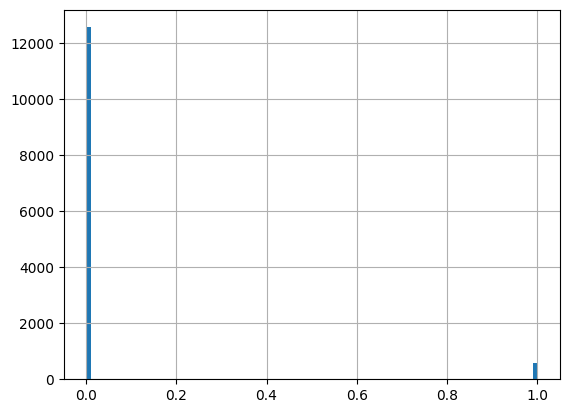

In [87]:
df_predictions_pd.match_probability.hist(bins=100)

<AxesSubplot: >

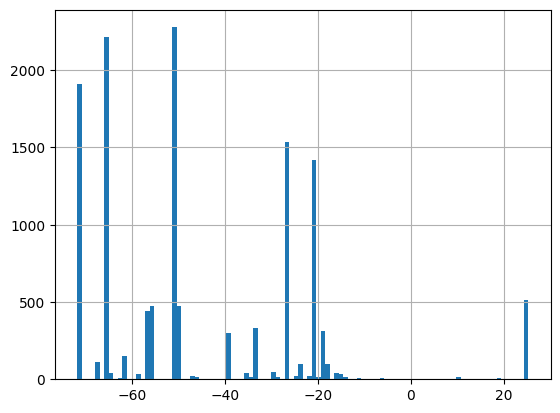

In [89]:
df_predictions_pd.match_weight.hist(bins=100)

# Look for a good cutoff value to declare a match

Just to make sure we're not missing anything, let's plot how many matches we'd get at different thresholds for probability or match weight.

Text(0, 0.5, 'number of matches')

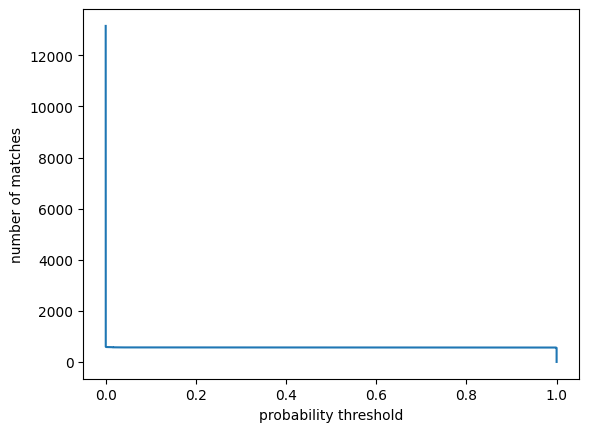

In [118]:
p = df_predictions_pd.match_probability.sort_values()
n = np.arange(len(p), 0, -1)
plt.plot(p,n)
plt.xlabel('probability threshold')
plt.ylabel('number of matches')

Text(0, 0.5, 'number of matches')

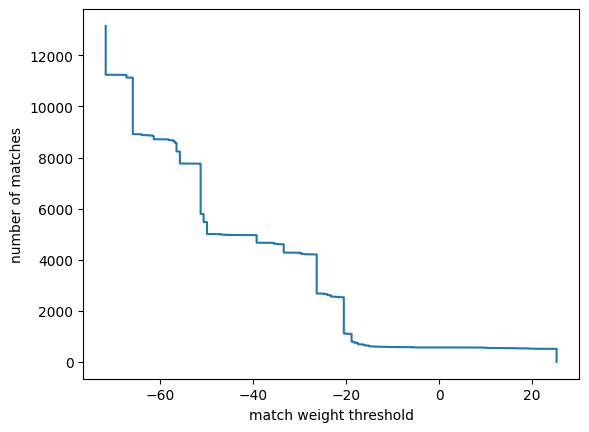

In [119]:
w = df_predictions_pd.match_weight.sort_values()
n = np.arange(len(w), 0, -1)
plt.plot(w,n)
plt.xlabel('match weight threshold')
plt.ylabel('number of matches')

# Pick a threshold and separate into links and non-links

Again we see that the possible links are extremely separated: If we pick any threshold between 0.042 and 0.998, we get the same matches and non-matches.

In [122]:
threshold_prob = 0.5
links = df_predictions_pd.match_weight > 0.5
df_links = df_predictions_pd.loc[links]
df_nonlinks = df_predictions_pd.loc[~links]
print(df_links.shape, df_nonlinks.shape, sep='\n')

(568, 29)
(12585, 29)


In [123]:
print("Minimum link probability:", df_links.match_probability.min())
print("Maximum non-link probability:", df_nonlinks.match_probability.max())

Minimum link probability: 0.9984602388266959
Maximum non-link probability: 0.04168012680940788


# Identify the missing kids!

Or at least, the kids we think are missing based on our predictions.



In [159]:
# Get kids in WIC data who we did not successfully link to census
df_missing_kids = df_wic.query("unique_id not in @df_links.unique_id_l")
df_missing_kids

,first_name,middle,last_name,date_of_birth,sex,race_ethnicity,address,zipcode,household_id,unique_id,age,relation_to_household_head
1319,Emma,Ava,Veliz,2016-09-24,Female,Latino,"1574 east 22 str alachua, fl",32615,582,13,NaN,NaN
2708,Elliott,Vincenzo,Radabaugh,2019-07-03,Male,White,"1569 park mdws dr hialeah, fl",33013,1185,31,NaN,NaN
3581,Kaylani,Journee,Sims,2018-08-05,Female,White,"121 scenic dr wst fernandina beach, fl",32034,1576,38,NaN,NaN
3969,Derek,Axel,Wilson,2017-11-30,Male,White,"14550 serenoa dr grand ridge, fl",32442,1743,46,NaN,NaN
4166,Kaliyah,Makayla,Scarlett,2019-08-11,Female,Black,"2600 comstock lane no bradenton, fl",34202,1827,49,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
46147,Peyton,Ryan,Gamboa,2017-07-27,Male,Latino,"1661 olive st fort lauderdale, fl",33316,19498,592,NaN,NaN
46792,Josiah,Colton,Lind,2016-06-20,Male,Latino,"5283 grovemont dr hialeah, fl",33166,19770,603,NaN,NaN
47112,William,William,Bahm,2018-05-01,Male,Latino,"423 sullivan st winter sprngs, fl",32708,19908,608,NaN,NaN
47639,Samuel,Connor,Mcintosh,2015-04-12,Male,White,"666 auburn ave sarasota, fl",34234,20123,615,NaN,NaN


# Do capture recapture?

number in first sample (census) x number in 2nd sample (WIC) / number in both

# Evaluation: Let's see how many true links we found...

Looks like we did a pretty darn good job. That was too easy.

## Get the true intersection

In [77]:
# Looks like we produced one fewer link than there should be (568 vs. 569)
kids_in_both = df_census_u5.index.intersection(df_wic.index)
kids_in_both.shape

(569,)

In [185]:
(df_census_u5.loc[kids_in_both])

,first_name,middle,last_name,date_of_birth,age,sex,race_ethnicity,relation_to_household_head,address,zipcode,unique_id,household_id
82,Sadie,K,Tidwell,2017-10-15,2.0,Female,Black,Biological child,"w 4th st north port, fl",34287,74,NaN
83,Liliana,NaN,Marshall,2019-12-03,0.0,Female,Black,Biological child,"w 4th st north port, fl",34287,75,NaN
174,Holly,E,Yount,2019-05-17,0.0,Female,White,Biological child,"7944 se 62nd ave unincorporated, fl",32824,161,NaN
306,Emilee,G,Haskew,2029-12-50,0.0,Female,Latino,Biological child,"749 mi ridge ests destin, fl",32541,282,NaN
323,Gunner,L,Parkinson,2020-03-03,0.0,Male,White,Biological child,"600 n maranantha rd hialeah, fl",33016,299,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
48269,Kaylee,T,Hill,2017-10-20,2.0,Female,Black,Biological child,"98 melanie dr pembroke pines, fl",33026,45885,NaN
48351,Lev,T,Dove,2018-10-18,1.0,Male,Black,Grandchild,"671 john muir road spring hill, fl",34610,45961,NaN
48442,Frederick,C,Rodriguez,2019-06-04,0.0,Male,Latino,Biological child,"5765 heards forest dr crestview, fl",32539,46049,NaN
48456,Liam,E,Sardone,2017-01-08,3.0,F,White,Biological child,"107 brown ave st. petersburg, fl",33704,46062,NaN


In [127]:
# Create a dataframe with all the truely matching records
df_true_links = (
    df_wic.loc[kids_in_both]
    .join(df_census_u5.loc[kids_in_both], lsuffix='_wic', rsuffix='_census')
)
df_true_links

,first_name_wic,middle_wic,last_name_wic,date_of_birth_wic,sex_wic,race_ethnicity_wic,address_wic,zipcode_wic,household_id_wic,unique_id_wic,...,last_name_census,date_of_birth_census,age_census,sex_census,race_ethnicity_census,relation_to_household_head_census,address_census,zipcode_census,unique_id_census,household_id_census
82,Sadie,Katia,Tidwell,2017-10-15,Female,Black,"w 4th st north port, fl",34287,48,1,...,Tidwell,2017-10-15,2.0,Female,Black,Biological child,"w 4th st north port, fl",34287,74,NaN
83,Liliana,Addisyn,Marshall,2019-12-03,Female,Black,"w 4th st north port, fl",34287,48,2,...,Marshall,2019-12-03,0.0,Female,Black,Biological child,"w 4th st north port, fl",34287,75,NaN
174,Holly,Emma,Yount,2019-05-17,Female,White,"7944 se 62nd ave unincorporated, fl",32824,88,3,...,Yount,2019-05-17,0.0,Female,White,Biological child,"7944 se 62nd ave unincorporated, fl",32824,161,NaN
306,Emilee,Guadalupe,Haskew,2019-12-30,Female,Latino,"749 mi ridge ests destin, fl",32541,150,4,...,Haskew,2029-12-50,0.0,Female,Latino,Biological child,"749 mi ridge ests destin, fl",32541,282,NaN
323,Gunner,Liam,Parkinson,2020-03-03,Male,White,"600 n maranantha rd hialeah, fl",33016,157,5,...,Parkinson,2020-03-03,0.0,Male,White,Biological child,"600 n maranantha rd hialeah, fl",33016,299,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48269,Kaylee,Trinity,Hill,2017-10-20,Female,Black,"98 melanie dr pembroke pines, fl",33026,20380,629,...,Hill,2017-10-20,2.0,Female,Black,Biological child,"98 melanie dr pembroke pines, fl",33026,45885,NaN
48351,Lev,Thomas,Dove,2018-10-18,Male,Black,"671 john muir road spring hill, fl",34610,20422,630,...,Dove,2018-10-18,1.0,Male,Black,Grandchild,"671 john muir road spring hill, fl",34610,45961,NaN
48442,Frederick,Cameron,Rodriguez,2019-06-04,Male,Latino,"5765 heards forest dr crestview, fl",32539,20452,631,...,Rodriguez,2019-06-04,0.0,Male,Latino,Biological child,"5765 heards forest dr crestview, fl",32539,46049,NaN
48456,Liam,Emmett,Sardone,2017-01-08,Male,White,"107 brown ave st. petersburg, fl",33704,20458,632,...,Sardone,2017-01-08,3.0,F,White,Biological child,"107 brown ave st. petersburg, fl",33704,46062,NaN


## Create MultiIndexes of the unique IDs so we can easily take set differences

In [132]:
true_links = pd.MultiIndex.from_frame(df_true_links[['unique_id_wic', 'unique_id_census']])
true_links

MultiIndex([(  1,    74),
            (  2,    75),
            (  3,   161),
            (  4,   282),
            (  5,   299),
            (  6,   323),
            (  7,   370),
            (  8,   812),
            (  9,   920),
            ( 10,   921),
            ...
            (624, 45701),
            (625, 45748),
            (626, 45759),
            (627, 45792),
            (628, 45865),
            (629, 45885),
            (630, 45961),
            (631, 46049),
            (632, 46062),
            (633, 46064)],
           names=['unique_id_wic', 'unique_id_census'], length=569)

In [131]:
df_predictions_pd.columns

Index(['match_weight', 'match_probability', 'source_dataset_l', 'unique_id_l',
       'source_dataset_r', 'unique_id_r', 'first_name_l', 'first_name_r',
       'gamma_first_name', 'bf_first_name', 'last_name_l', 'last_name_r',
       'gamma_last_name', 'bf_last_name', 'date_of_birth_l', 'date_of_birth_r',
       'gamma_date_of_birth', 'bf_date_of_birth', 'sex_l', 'sex_r',
       'gamma_sex', 'bf_sex', 'zipcode_l', 'zipcode_r', 'gamma_zipcode',
       'bf_zipcode', 'address_l', 'address_r', 'match_key'],
      dtype='object')

In [138]:
found_links = pd.MultiIndex.from_frame(df_links[['unique_id_l', 'unique_id_r']])
found_links

MultiIndex([(  3,   161),
            (  9,   920),
            ( 11,   986),
            ( 26,  2283),
            ( 32,  2882),
            ( 33,  2910),
            ( 34,  3049),
            ( 39,  3411),
            ( 43,  3623),
            ( 45,  3700),
            ...
            (196, 14651),
            (248, 18033),
            (270, 19566),
            (285, 20892),
            (406, 30570),
            (409, 30647),
            (413, 30789),
            (538, 40082),
            ( 23,  1751),
            (140, 10060)],
           names=['unique_id_l', 'unique_id_r'], length=568)

## Looks like we found all the true links except one, and we din't find any links we shouldn't have

That's great! For this application, it's better to count a few kids as missing even if they aren't than to erroneously link a kid that's actually missing to someone already in the census:

- In the first case, we'd look into the missing kid and eventually figure out that they weren't actually missing, whereas

- In the second case, we'd miss the kid again and still have no idea.

In [139]:
# True links we missed (1 false negative)
true_links.difference(found_links)

MultiIndex([(361, 27996)],
           )

In [141]:
# Links we found that are wrong (0 false positives)
found_links.difference(true_links)

MultiIndex([], )

# Look into why we missed the above link

Even though this is a pretty good result, let's see why we didn't link the one kid we should have.

Looks like the main problem is that the last name in the census was "Unknown", a fake name. So to improve our linkage, we should replace fake names with `NaN` so that they're treated as missing. 

In [143]:
df_wic.query("unique_id == 361")

,first_name,middle,last_name,date_of_birth,sex,race_ethnicity,address,zipcode,household_id,unique_id,age,relation_to_household_head
29442,Aidan,Hunter,Knight,2015-10-25,Male,White,"595 ne 799 st altamonte springs, fl",32714,12450,361,NaN,NaN


In [145]:
df_census_u5.query("unique_id == 27996")

,first_name,middle,last_name,date_of_birth,age,sex,race_ethnicity,relation_to_household_head,address,zipcode,unique_id,household_id
29442,Aidwn,H,Unknown,2015-10-29,4.0,Male,White,Biological child,"595 ne 799 st altamonte springs, fl",32714,27996,NaN


In [146]:
df_predictions_pd.query("unique_id_l == 361 and unique_id_r == 27996")

,match_weight,match_probability,source_dataset_l,unique_id_l,source_dataset_r,unique_id_r,first_name_l,first_name_r,gamma_first_name,bf_first_name,...,sex_r,gamma_sex,bf_sex,zipcode_l,zipcode_r,gamma_zipcode,bf_zipcode,address_l,address_r,match_key
9346,-7.094401,0.007265,_a,361,_b,27996,Aidan,Aidwn,2,8.133641,...,Male,1,2.007301,32714,32714,3,325.443229,"595 ne 799 st altamonte springs, fl","595 ne 799 st altamonte springs, fl",2


In [150]:
# Create a Series for the missed link, which can be used as a dict
missed_link = df_predictions_pd.loc[9346]
# We can pass the Series to waterfall_chart, which takse a list of dict
linker.waterfall_chart([missed_link], filter_nulls=False)

# See how different the common records were between WIC and census

Not very different. Only 53 out of 569 common records have any difference at all, and it looks like there's usually only a difference in one column.

In [187]:
columns = ['first_name', 'last_name', 'date_of_birth', 'sex', 'zipcode']
df_wic.loc[kids_in_both, columns].compare(df_census_u5.loc[kids_in_both, columns])

first_name             last_name              date_of_birth              \
            self    other         self        other          self       other   
306          NaN      NaN          NaN          NaN    2019-12-30  2029-12-50   
401      Julissa  Lady Of          NaN          NaN           NaN         NaN   
1850         NaN      NaN      Blevins       Person           NaN         NaN   
3075      Inaaya   Inaaia          NaN          NaN           NaN         NaN   
3221         NaN      NaN  Tranquilino  Tranqui|ino           NaN         NaN   
...          ...      ...          ...          ...           ...         ...   
45963        NaN      NaN          NaN          NaN    2018-11-21  2018-21-11   
46973        NaN      NaN          NaN          NaN           NaN         NaN   
48125        NaN      NaN          NaN          NaN           NaN         NaN   
48171    Kailani  Kaulani          NaN          NaN           NaN         NaN   
48456        NaN      NaN          NaN          NaN           NaN         NaN   

        sex       zipcode         
       self other    self  other  
306     NaN   NaN     NaN    NaN  
401     NaN   NaN     NaN    NaN  
1850    NaN   NaN     NaN    NaN  
3075    NaN   NaN     NaN    NaN  
3221    NaN   NaN     NaN    NaN  
...     ...   ...     ...    ...  
45963   NaN   NaN     NaN    NaN  
46973   NaN   NaN   32137  32135  
48125  Male     F     NaN    NaN  
48171   NaN   NaN     NaN    NaN  
48456  Male     F     NaN    NaN  

[53 rows x 10 columns]

# See why simulant 401 matched whereas simulant 29442 didn't, when both of them had a fake name.

It looks like matching last names carry more weight than matching first names, and simulant 401 had matching birthdays whereas simulant 29442's birthday was off by one character. Those two differences between the record comparisons made a large difference in the final probability of the link.

In [193]:
simulant_id = 401
wic_id, census_id = df_true_links.loc[simulant_id, ['unique_id_wic', 'unique_id_census']]
record = df_predictions_pd.query("unique_id_l == @wic_id and unique_id_r == @census_id")
linker.waterfall_chart([record.squeeze()], filter_nulls=False)

In [ ]:
missed_link = df_predictions_pd.loc[9346]
# We can pass the Series to waterfall_chart, which takse a list of dict
linker.waterfall_chart([missed_link], filter_nulls=False)

## Compare true missing kids to those we declared missing

To double check the above false negative, see which simulants in the *entire* census (not restricted to age < 5) show up in our declared missing kids. There's still only one, and it's the kid we identified above. (Ok, well of course we couldn't get any additional false positives, because all the IDs in the missing kids dataframe must have come from kids < 5 in the census.)

In [175]:
# Kids in census who we erroneously said were missing
falsely_missing = df_census.index.intersection(df_missing_kids.index)
falsely_missing

Int64Index([29442], dtype='int64')

In [176]:
df_census.loc[falsely_missing]

,first_name,middle,last_name,date_of_birth,age,sex,race_ethnicity,relation_to_household_head,address,zipcode,unique_id,household_id
29442,Aidwn,H,Unknown,2015-10-29,4.0,Male,White,Biological child,"595 ne 799 st altamonte springs, fl",32714,27996,NaN


In [166]:
# Kids we correctly identified as missing from the census
truly_missing = df_missing_kids.index.difference(df_census.index)
truly_missing

Int64Index([ 1319,  2708,  3581,  3969,  4166,  6791,  7584,  7756,  8234,
             8723,  9777, 10696, 11409, 11893, 11979, 12522, 12611, 12918,
            13764, 15103, 15568, 16628, 17420, 19580, 20441, 20782, 21277,
            21607, 22048, 23127, 23158, 23284, 23298, 26593, 28259, 29548,
            29994, 30178, 31043, 31744, 32223, 32258, 33954, 35468, 36507,
            37196, 37201, 38189, 38429, 38481, 39788, 40671, 41037, 41485,
            42899, 43049, 44098, 44247, 44561, 46147, 46792, 47112, 47639,
            48004],
           dtype='int64')

In [179]:
# Check that "truly missing" is the same as "missing but not falsely missing"
not_falsely_missing = df_missing_kids.index.difference(falsely_missing)
df_missing_kids.loc[truly_missing].equals(df_missing_kids.loc[not_falsely_missing])

True

In [182]:
# Check that who we identified as truly missing matches the IDs
# we get by comparing the original two dataframes
(df_wic.index.difference(df_census.index) == truly_missing).all()

True

# Possible improvements

## Ways to make linking harder

1. Add missingness to more fields

1. Increase the overall noise level

1. Add more noise to age (e.g., allow ages to be off by more than one year and/or apply noise to more rows) so that I don't get all the matches in the first round

1. Adapt my noise functions to run on the larger data sets that only have IDs instead of names and addresses, so that I can try to link a larger data set

1. Add a noise function that puts names in the wrong field (e.g., put first name where last name or middle name goes, or vice/versa)

1. Add a noise function that replaces names with nicknames

1. Add a noise function that replaces "Male" and "Female" with "M" and "F", or something like that

1. Get rid of zipcode comparison

## Ways to make linking process better

1. Use term frequency adjustments (I'm not sure what this does)

1. Do more preprocessing of data:

   1. Replace fake names with "missing" (i.e. `NaN`). Note: To better mimic reality where you probably wouldn't catch every single fake name, I could choose a random subset of the fake names and replace those with `NaN`.
   
1. Possibly try using a different comparison function for zipcodes (e.g., add more thresholds to Levenshtein, or try Jaro-Winkler)

1. Fix my noise function for `sex` to use `'Male'` and '`Female`' rather than `'M'` and `'F'`

# Take-aways

## What did I learn that's relevant to our pipeline design or simulated data?

1. I don't think I could create a realistic pipeline because my data wasn't realistic enough: It was too small, and the noise was too simple, both of which made the linking process much easier than it would be for a real dataset, which I think means that I am missing a lot of the demands that would be placed on a real system. Examples:

   1. I got all the links on my first pass, so I didn't have to go to my second planned step of the cascade.
   
   1. The data is very small, so I didn't have to think very carefully about choosing good blocking rules and making sure everything could run with my available resources.
   
   1. My estimated probabilities were extremely separated, meaning that I didn't have to do any work to choose a threshold to decide how to separate matches from non-matches. I'm not sure why the estimated probabilities were so well-separated, but it might be that the amount or type of noise in the data was insufficient to cause the linking algorithm any substantial challenges.
   
   1. All the noise functions are independent, which I think means that most of the noisy records should be comparably difficult to match (which, according to my previous point, seems to be insufficiently difficult). In reality, I suspect that there will be a small fraction of records that are much harder to match than others, which would probably be a lot more challenging to the linking algorithm.
   
1. The output of my preprocessing step was specific to Splink. Different systems will have differerent conventions, so we'll need to standardize these somehow.

1. I had an intermediate step where I saved the trained model to run later.

1. My final output was a list of records in WIC data that had no match in census data. To get this, I first got a list of the matching records, then I had to extract unique IDs of the WIC records that matched so that I could filter those out of the WIC data.

1. To decide which pairs of records were links, I needed to choose a threshold. In general it seems like there may be no clear way to do this, but it would be helpful to have some tools to facilitate this, like the graphs I drew above. Are there any other ways of evaluating potential thresholds when you don't have labeled data?

1. It would be nice to have good defaults for the noise functions so that when I want to simulate a linking task, I won't have to tinker around with the parameters to have a somewhat realistic challenge.